<a href="https://colab.research.google.com/github/maxla777/Project-2/blob/Monique/Monique/ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive with Colab Notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import the needed libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Import to scale the data
from sklearn.preprocessing import StandardScaler

# Imports for the AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Imports for evaluation metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, classification_report, precision_recall_curve, roc_auc_score, hamming_loss, jaccard_score, matthews_corrcoef

# Data Preparation

In [4]:
# Load the sentiment signals data and check the data
# Set the file path
csv_path = Path('/content/drive/MyDrive/Colab Notebooks/ETH_bull_bear_signals.csv')
# Read the data
df_crypto_news=pd.read_csv(csv_path)
# Set the date column as the index
df_crypto_news.set_index(pd.to_datetime(df_crypto_news['date'], infer_datetime_format=True), inplace=True)
# Drop the date column since the date is now the index
df_crypto_news.drop(columns=['date'], inplace=True)
# Display the DataFrame - first few rows
df_crypto_news.head()

,signal
date,
2020-12-01,1.0
2020-12-02,0.0
2020-12-03,0.0
2020-12-04,1.0
2020-12-05,0.0


In [5]:
# Display the DataFrame - last few rows
df_crypto_news.tail()

,signal
date,
2021-03-17,0.0
2021-03-18,0.0
2021-03-19,0.0
2021-03-20,-1.0
2021-03-21,-1.0


In [6]:
# Load the technical signals data and check the data
# Set the file path
csv_path = Path('/content/drive/MyDrive/Colab Notebooks/kraken_pull_EthExample_03212021.csv')
# Read the data
df_eth_returns=pd.read_csv(csv_path)
# Set the Date column as the index
df_eth_returns.set_index(pd.to_datetime(df_eth_returns['Date'], infer_datetime_format=True), inplace=True)
# Drop the Date column since it is now the index
df_eth_returns.drop(columns=['Date'], inplace=True)
# Copy the crossover signal, volume trend signal, bollinger signal, RSI signal, and Positive Return columns
df_eth_returns = df_eth_returns[['crossover_signal', 'vol_trend_signal', 'bollinger_signal', 'RSI_signal','Positive Return']].copy()
# Add in the sentiment signal to the DataFrame
df_eth_returns['sentiment_signal'] = df_crypto_news[['signal']].copy()
# Display the DataFrame - first few rows
df_eth_returns.head()

,crossover_signal,vol_trend_signal,bollinger_signal,RSI_signal,Positive Return,sentiment_signal
Date,,,,,,
2020-11-12,1.0,1.0,0.0,0.0,0.0,NaN
2020-11-13,1.0,1.0,0.0,0.0,1.0,NaN
2020-11-14,1.0,1.0,0.0,0.0,0.0,NaN
2020-11-15,1.0,-1.0,0.0,0.0,0.0,NaN
2020-11-16,1.0,1.0,0.0,0.0,1.0,NaN


In [7]:
# Display the DataFrame - last few rows
df_eth_returns.tail()

,crossover_signal,vol_trend_signal,bollinger_signal,RSI_signal,Positive Return,sentiment_signal
Date,,,,,,
2021-03-18,1.0,1.0,0.0,0.0,0.0,0.0
2021-03-19,1.0,1.0,0.0,0.0,1.0,0.0
2021-03-20,1.0,1.0,0.0,0.0,0.0,-1.0
2021-03-21,1.0,1.0,0.0,0.0,0.0,-1.0
2021-03-22,1.0,1.0,0.0,0.0,0.0,NaN


In [8]:
# Drop the NAs
df_eth_returns.dropna(inplace=True)
# df_eth_returns.isna().sum()
# df_eth_returns.head() # Check the first few rows
df_eth_returns.tail() # Check the last few rows

,crossover_signal,vol_trend_signal,bollinger_signal,RSI_signal,Positive Return,sentiment_signal
Date,,,,,,
2021-03-17,1.0,1.0,0.0,0.0,1.0,0.0
2021-03-18,1.0,1.0,0.0,0.0,0.0,0.0
2021-03-19,1.0,1.0,0.0,0.0,1.0,0.0
2021-03-20,1.0,1.0,0.0,0.0,0.0,-1.0
2021-03-21,1.0,1.0,0.0,0.0,0.0,-1.0


In [9]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal', 'RSI_signal','sentiment_signal']

# Construct training start and end dates
training_start = df_eth_returns.index.min().strftime(format= '%Y-%m-%d')
training_end = '2021-02-16'

# Construct testing start and end dates
testing_start =  '2021-02-17'
testing_end = df_eth_returns.index.max().strftime(format= '%Y-%m-%d')

# Construct the X_train and y_train datasets
X_train = df_eth_returns[x_var_list][training_start:training_end]
y_train = df_eth_returns['Positive Return'][training_start:training_end]

# Construct the X test and y test datasets
X_test = df_eth_returns[x_var_list][testing_start:testing_end]
y_test = df_eth_returns['Positive Return'][testing_start:testing_end]

# Print training and testing start/end dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")

Training Start: 2020-12-01
Training End: 2021-02-16
Testing Start: 2021-02-17
Testing End: 2021-03-21


In [10]:
#Create the StandardScaler instance
scaler = StandardScaler()

In [11]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)

In [12]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Evaluation Metrics Functions

In [13]:
# Create function to calculate and display the confusion matrix
def get_confusion_matrix(y_test, predictions):
  cm = confusion_matrix(y_test, predictions) # calculate the confusion matrix
  # Create a DataFrame for the confusion matrix
  cm_df = pd.DataFrame(
      cm, index=['Actual Not Positive', 'Actual Positive'],
      columns=['Predicted Not Positive', 'Predicted Positive']
  )
  # Print a header for the confusion matrix
  print("Confusion Matrix")
  # Display the confusion matrix
  display(cm_df)

In [14]:
# Create a function to calculate and display the evaluation metrics
def get_scores(X_test, y_test, predictions, model):
  # Calculate the accuracy score
  acc_score = accuracy_score(y_test, predictions)
  # Calculate the balanced accuracy score
  bal_acc_score = balanced_accuracy_score(y_test, predictions)
  # Predict the class probabilities
  probs = model.predict_proba(X_test)[:,1]
  # Calculate the precision-recall pairs
  precision, recall, _ = precision_recall_curve(y_test, probs, pos_label=1)
  # Calculate the area under the curve AUPRC
  auprc_score = roc_auc_score(y_test, probs)
  # Calculate the Matthews correlation coefficient MCC
  MCC_score = matthews_corrcoef(y_test, predictions)
  # Calculate the Jaccard similarity coefficient
  J_score = jaccard_score(y_test, predictions)
  # Calculate the average Hamming loss
  H_loss = hamming_loss(y_test, predictions)
  # Create a DataFrame for the accuracy, balanced accuracy, MCC, Jaccard, and average Hamming loss scores
  scores_df = pd.DataFrame(
      [acc_score, bal_acc_score, MCC_score, J_score, H_loss], 
      index=['Accuray', 'Balanced Accuracy', 'Matthews Correlation Coefficient', 'Jaccard Similarity Coefficient', 'Average Hamming Loss'],
      columns=['Scores']
  )
  # Create a classification report
  class_report = classification_report(y_test, predictions, target_names= ['Not Positive', 'Positive'])
  # Set up to plot the precision-recall curve
  plt.plot(recall, precision, marker='o')
  # Display the scores DataFrame
  display(scores_df)
  # Print the classification report
  print('Classification Report:')
  print(class_report)
  # Print the precision-recall curve header
  print('Precision-Recall Curve')
  # Print the area under the curve score
  print('Area Under the Curve:', auprc_score)
  # Show the precision-recall curve plot
  plt.show()

# AdaBoost

In [15]:
# Fit a SKLearn linear regression using the training set (X_train, y_train):
AB_model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=100,
    learning_rate=1,
    random_state=0
)
AB_model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
AB_predictions = AB_model.predict(X_test)

# Assemble actual y data (y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = AB_predictions
Results

,Positive Return,Predicted Value
Date,,
2021-02-17,1.0,1.0
2021-02-18,1.0,1.0
2021-02-19,1.0,0.0
2021-02-20,0.0,0.0
2021-02-21,1.0,1.0
2021-02-22,0.0,1.0
2021-02-23,0.0,1.0
2021-02-24,1.0,1.0
2021-02-25,0.0,1.0


In [16]:
print(AB_model.get_params()) # looked at parameters and experimented with them to see if they made significant differences

{'algorithm': 'SAMME.R', 'base_estimator__ccp_alpha': 0.0, 'base_estimator__class_weight': None, 'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 2, 'base_estimator__max_features': None, 'base_estimator__max_leaf_nodes': None, 'base_estimator__min_impurity_decrease': 0.0, 'base_estimator__min_impurity_split': None, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'base_estimator__min_weight_fraction_leaf': 0.0, 'base_estimator__presort': 'deprecated', 'base_estimator__random_state': None, 'base_estimator__splitter': 'best', 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None

[]

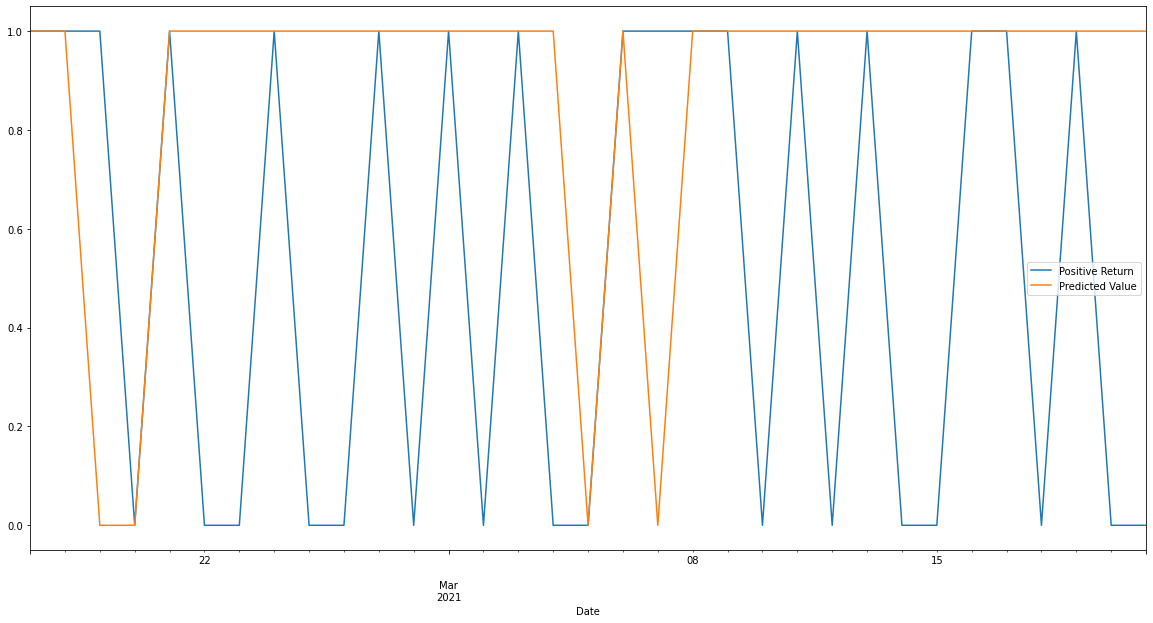

In [17]:
# Assign results to the AB_Results variable and plot
AB_Results = Results[['Positive Return','Predicted Value']].plot(figsize=(20,10))
# Save the plot
AB_Results.get_figure().savefig('/content/drive/MyDrive/Colab Notebooks/AB_results_combined', bbox_inches="tight")
# Display the plot
AB_Results.plot(figsize=(20,10))

## Features

In [18]:
# Look at the feature importances
AB_importances = AB_model.feature_importances_

AB_importances_sorted = sorted(zip(AB_model.feature_importances_, df_eth_returns[x_var_list].columns), reverse=True)
AB_importances_sorted

[(0.40421254866613593, 'sentiment_signal'),
 (0.2682679330478492, 'bollinger_signal'),
 (0.22700938145128313, 'RSI_signal'),
 (0.10051013683473174, 'vol_trend_signal'),
 (0.0, 'crossover_signal')]

## Metrics

In [19]:
# Calculate the confusion matrix using the defined function
get_confusion_matrix(y_test, AB_predictions)

Confusion Matrix


,Predicted Not Positive,Predicted Positive
Actual Not Positive,2,14
Actual Positive,2,15


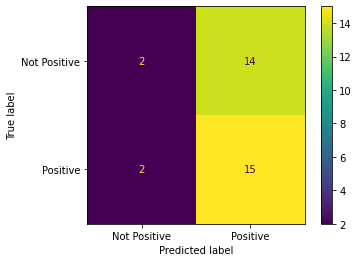

In [20]:
# Plotting the confusion matrix and saving the figure
AB_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, AB_predictions), display_labels=['Not Positive', 'Positive'])
AB_disp.plot()
# AB_disp.show()
# AB_disp.plot().savefig('/content/drive/MyDrive/Colab Notebooks/AB_confusion_matrix.png')

,Scores
Accuray,0.515152
Balanced Accuracy,0.503676
Matthews Correlation Coefficient,0.011259
Jaccard Similarity Coefficient,0.483871
Average Hamming Loss,0.484848


Classification Report:
              precision    recall  f1-score   support

Not Positive       0.50      0.12      0.20        16
    Positive       0.52      0.88      0.65        17

    accuracy                           0.52        33
   macro avg       0.51      0.50      0.43        33
weighted avg       0.51      0.52      0.43        33

Precision-Recall Curve
Area Under the Curve: 0.5220588235294118


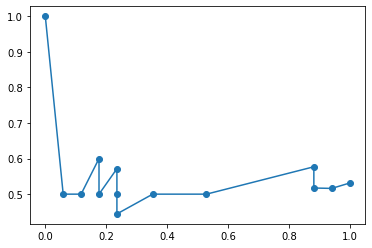

In [21]:
# Calculate all the evaluation metrics using the defined score function
get_scores(X_test, y_test, AB_predictions, AB_model)

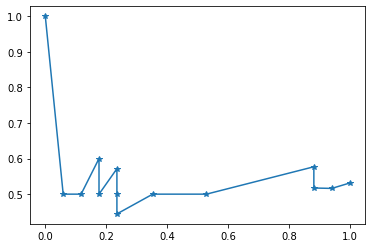

In [22]:
# Predict class probabilities for the features 
# AB_probs = AB_model.predict_proba(X_test)[:,1]
# Compute precision-recall pairs
# AB_precision, AB_recall, _ = precision_recall_curve(y_test, AB_probs, pos_label=1)
# plt.plot(AB_recall, AB_precision, marker='*')
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/AB_PR_Curve.png')

## Save Model

In [23]:
# Save the model once satisfied with results
# from joblib import dump, load
# dump(AB_model, 'AdaBoost_model.joblib') 

# Load saved model to use on other datasets
# AB_model = load('AdaBoost_model.joblib') 


# Random Forest

In [24]:
# Fit a SKLearn linear regression using just the training set (X_train, y_train):
RF_model = RandomForestClassifier(n_estimators=100, 
                               max_depth=2, # when max_depth = 1, nothing is predicted not positive
                               criterion='gini', # gini or entropy, gini is default
                               random_state=0)
RF_model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
RF_predictions = RF_model.predict(X_test)

# Assemble actual y data (y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = RF_predictions
Results

,Positive Return,Predicted Value
Date,,
2021-02-17,1.0,1.0
2021-02-18,1.0,1.0
2021-02-19,1.0,0.0
2021-02-20,0.0,1.0
2021-02-21,1.0,1.0
2021-02-22,0.0,1.0
2021-02-23,0.0,1.0
2021-02-24,1.0,1.0
2021-02-25,0.0,1.0


In [25]:
print(RF_model.get_params()) # looked at parameters and experimented with them to see if they made significant differences

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


[]

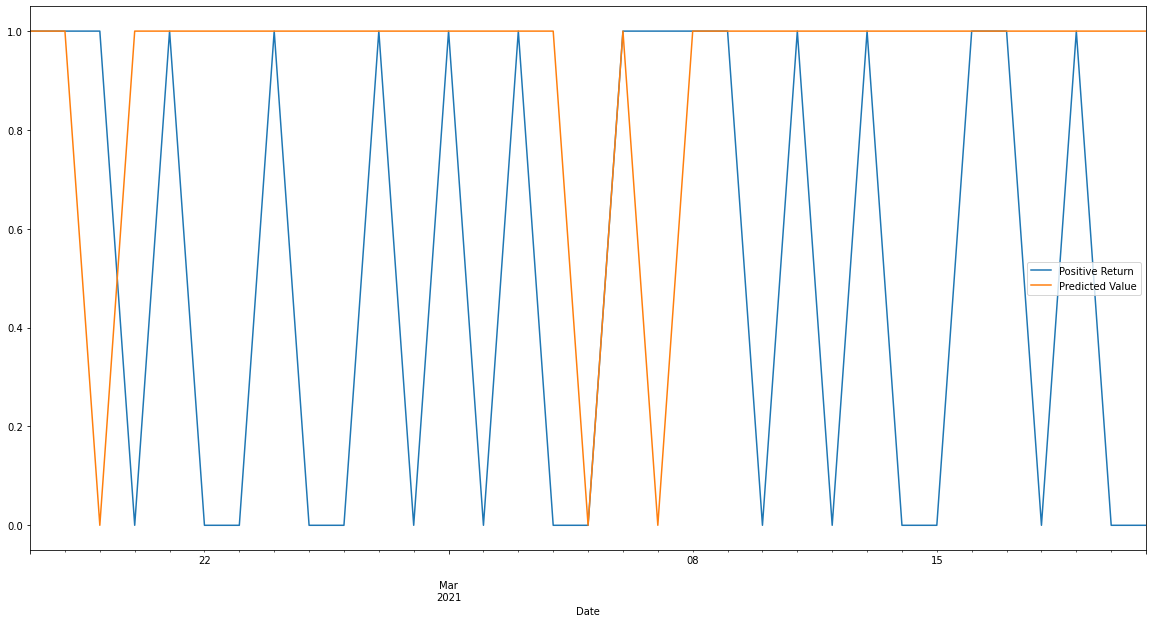

In [26]:
# Assigned results to the RF_Results variable and plotted the results
RF_Results = Results[['Positive Return','Predicted Value']].plot(figsize=(20,10))
# Saved the plot
RF_Results.get_figure().savefig('/content/drive/MyDrive/Colab Notebooks/RF_results_combined', bbox_inches="tight")
RF_Results.plot(figsize=(20,10))

## Features

In [27]:
# Looked at the feature importances
RF_importances = RF_model.feature_importances_

RF_importances_sorted = sorted(zip(RF_model.feature_importances_, df_eth_returns[x_var_list].columns), reverse=True)
RF_importances_sorted

[(0.3585310895686061, 'vol_trend_signal'),
 (0.28998011122438416, 'sentiment_signal'),
 (0.18285333769021012, 'bollinger_signal'),
 (0.16863546151679973, 'RSI_signal'),
 (0.0, 'crossover_signal')]

## Metrics

In [28]:
# Calculate the confusion matrix using the defined function
get_confusion_matrix(y_test, RF_predictions)

Confusion Matrix


,Predicted Not Positive,Predicted Positive
Actual Not Positive,1,15
Actual Positive,2,15


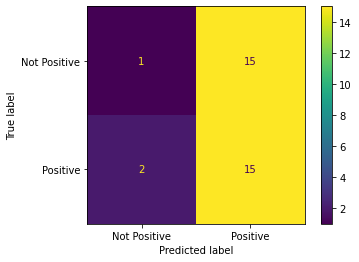

In [29]:
# Plotting the confusion matrix and saving the figure
RF_disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, RF_predictions), display_labels=['Not Positive', 'Positive'])
RF_disp.plot()
# RF_disp.show()
# RF_disp.plot().savefig('/content/drive/MyDrive/Colab Notebooks/RF_confusion_matrix.png')

,Scores
Accuray,0.484848
Balanced Accuracy,0.472426
Matthews Correlation Coefficient,-0.095871
Jaccard Similarity Coefficient,0.468750
Average Hamming Loss,0.515152


Classification Report:
              precision    recall  f1-score   support

Not Positive       0.33      0.06      0.11        16
    Positive       0.50      0.88      0.64        17

    accuracy                           0.48        33
   macro avg       0.42      0.47      0.37        33
weighted avg       0.42      0.48      0.38        33

Precision-Recall Curve
Area Under the Curve: 0.3713235294117647


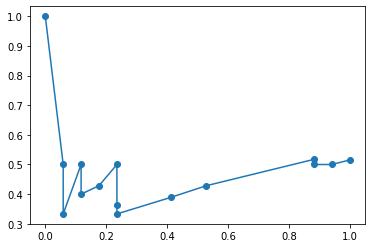

In [30]:
# Calculate all the evaluation metrics using the defined score function
get_scores(X_test, y_test, RF_predictions, RF_model)

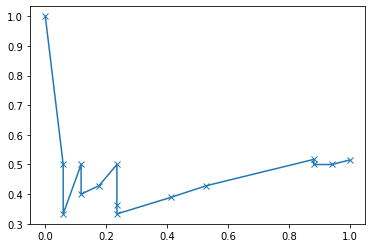

In [31]:
# Predict class probabilities for the features 
# RF_probs = RF_model.predict_proba(X_test)[:,1]
# Compute precision-recall pairs
# RF_precision, RF_recall, _ = precision_recall_curve(y_test, RF_probs, pos_label=1)
# plt.plot(RF_recall, RF_precision, marker='x')
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/RF_PR_Curve.png')

## Save Random Forest Model

In [32]:
# Save the model once satisfied with results
# from joblib import dump, load
# dump(RF_model, 'RandomForest_model.joblib') 

# Load saved model to use on other datasets
# RF_model = load('RandomForest_model.joblib') 
